# Work starting on January 19th: Part 1

Look at the effect of different starting values of defocus on the final defocus value reached and the images produced.

In [1]:
import pyms
import numpy as np
import torch
import time
from pyms.Probe import aberration
from copy import deepcopy
import matplotlib.pyplot as plt

from pyms.utils.torch_utils import (
    amplitude,
    crop_to_bandwidth_limit_torch,
    size_of_bandwidth_limited_array,
    amplitude,
)

from pyms.Probe import (
    make_contrast_transfer_function,
)

%matplotlib inline

#crystal = pyms.structure.fromfile(
#    "Structures/SrTiO3_CeO2_interface.xyz", atomic_coordinates="cartesian"
#)

crystal = pyms.structure.fromfile(
    "/home/hremadmin/py_multislice_differentiable/py_multislice_differentiable_tem/Demos/Structures/SrTiO3_CeO2_interface.xyz", atomic_coordinates="cartesian"
)

# A few maniupulations to remove vaccuum at edges and create a psuedo-periodic structure
crystal = crystal.resize([0.1, 0.76], axis=0)

other = deepcopy(crystal).resize([0.017, 0.99], axis=0)
other.reflect([0])
crystal = crystal.concatenate(other, axis=0)

# Subslicing of crystal for multislice
subslices = [0.33, 0.66, 1.0]

# Grid size in pixels
gridshape = [1024, 1024]

# Tile structure in multislice for a square grid
tiling = [1, 7]

# Probe accelerating voltage in eV
eV = 3e5

# Objective aperture in mrad
app = 15

# No aperture is also an option
# app = None

# Set up series of thicknesses
thicknesses = np.array([100])


In [2]:
# Establish aberrations
# Just defocus for now

def establish_aberrations(df_value):
    """Create a list of aberrations. Initialise with starting values."""

    aberrations = []

    # Initial guesses for aberrations
    df = df_value

    # Krivanek aberration coefficient, Haider aberration coefficient, colloquial name, amplitude, angle, n, m
    # n and m are constants (shouldn't be differentiable), amplitude and angle should be

    aberrations.append(aberration("C10", "C1", "Defocus          ", torch.tensor([df], requires_grad = True), 0.0, 1, 0.0))
    
    return aberrations


In [3]:
# Set up our initial guess for the crystal HRTEM
# It uses the aberrations (including defocus) as set above

def create_initial_guess(aberrations):

    output = pyms.HRTEM(
        crystal,
        gridshape,
        eV,
        app,
        thicknesses,
        subslices=subslices,
        aberrations=aberrations,
        df= aberrations[0].amplitude,
        tiling=tiling,
        nfph=1,
        showProgress='notebook', 
        apply_ctf = False,
    )
    #plt.imshow(torch.abs(output).detach().cpu().numpy(), vmax = 10)
    
    return output

In [4]:
def save_sim_image(sim_image, df_value):
    plt.imshow(sim_image[0].detach().cpu().numpy())

    plt.title(u'Simulated image of SrTiO\u2083\n with initial defocus value of {value}'.format(value=df_value), fontsize=15)
    plt.xticks([])
    plt.yticks([])

    filepath = "/home/hremadmin/Documents/Project/ML_files/Work_Jan_19/Part_1_just_df/Initial_df_value/simulated_image_"+ str(df_value) + ".jpg"
    plt.savefig(filepath, dpi=500)
    print("Saved")

In [17]:
def optimise(aberrations, output, ref_data, n_iters, learning_rate, loss_multiplier, df_value):
    """Go through and refine the aberrations to minimise difference between initial guess (output) and experimental image"""

    bw_limit_size = size_of_bandwidth_limited_array(gridshape)
    rsize = np.asarray(crystal.unitcell[:2]) * np.asarray(tiling)

    curves = []
    params = []

    # Generic form allows more flexibility if we decided to not include some aberrations in the future.
    for i in range(0, len(aberrations)):
        params.append(aberrations[i].amplitude)
        curves.append([])

    optimizer = torch.optim.Adam(params, lr = learning_rate)
    criterion = torch.nn.MSELoss()

    loss_curve = []


    start = time.time()

    for iter in range(n_iters):
        ctf = (
                torch.stack(
                    [
                        make_contrast_transfer_function(
                            bw_limit_size, rsize, eV, app, df=aberrations[0].amplitude, aberrations=aberrations
                        )
                    ]
                )
            .type(torch.complex128)
            .to('cpu') # changed cuda to cpu
        )

        sim_image = amplitude(torch.fft.ifftn(ctf * output, dim=(-2, -1)))

        optimizer.zero_grad()

        loss = criterion(sim_image, ref_data)*loss_multiplier

        loss.backward()

        optimizer.step()

        loss_curve.append(loss.item())


        for i in range(0,len(curves)):
            curves[i].append(aberrations[i].amplitude.item())


    end = time.time()
    
    runtime = end-start
    
    #save_sim_image(sim_image, df_value)
    
    print((aberrations[0].amplitude.grad)) # should be zero for a df=200 (GT) starting point
    
    return runtime, loss.item(), aberrations[0].amplitude.item()

    #print("Time to run:", str((end - start)))
    #print("Loss", str(loss.item())) # Final loss value
    #print("Final defocus value", str(aberrations[0].amplitude.item()))

In [6]:
def main(n_iters, learning_rate, loss_multiplier, df_value):
    aberrations = establish_aberrations(df_value)
    output = create_initial_guess(aberrations)
    
    # Load in "experimental" data
    path = '/home/hremadmin/Documents/Project/differentiable/df_200_test_data.npy'
    ref_data = np.load(path)
    ref_data = torch.tensor(ref_data).to('cpu')
    
    runtime, loss, defocus_final = optimise(aberrations, output, ref_data, n_iters, learning_rate, loss_multiplier, df_value)
    return runtime, loss, defocus_final
    
    

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


/home/hremadmin/py_multislice_differentiable/py_multislice_differentiable_tem/pyms/Premixed_routines.py:1520: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  for df_ in defocii


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

/home/hremadmin/miniconda3/envs/pyms_2/lib/python3.6/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([683, 683])) that is different to the input size (torch.Size([1, 683, 683])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved


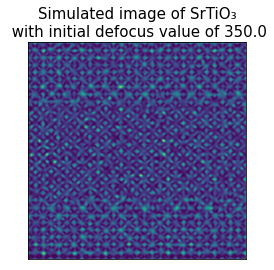

In [8]:
# Initially starting values of defocus.
# The ground truth is df = 200
df_values = [0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 175.0, 200.0, 225.0, 250.0, 275.0, 300.0, 325.0, 350.0]

# Constants
n_iterations = 2000
learning_rate = 1e-1
loss_multiplier = 1e9

runtimes = []
losses = []
defocus_values = []

for i in df_values:
    runtime, loss, defocus_final = main(n_iterations, learning_rate, loss_multiplier, i)
    runtimes.append(runtime)
    losses.append(loss)
    defocus_values.append(defocus_final)


I want to save this data somewhere so I don't have to rerun stuff to get the data.

In [13]:
# Saving data to file code

filename = "Variation_initial_df_values.txt"

f = open(filename, "w")
x = "Initial defocus value, Loss, Final defocus value, time to run"
f.write(x)
f.write("\n")

for i in range(0, len(df_values)):
    line = str(df_values[i]) +  ", " + str(losses[i]) + ", " + str(defocus_values[i]) + ", " + str(runtimes[i])
    f.write(line)
    f.write("\n")

f.close() 

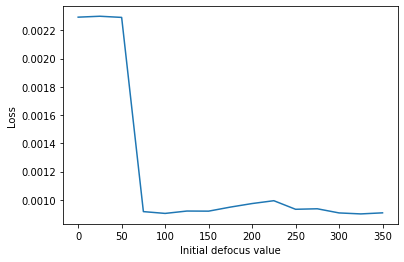

In [14]:
plt.plot(df_values, losses)
plt.ylabel('Loss')
plt.xlabel('Initial defocus value')

filepath = "/home/hremadmin/Documents/Project/ML_files/Work_Jan_19/Part_1_just_df/Initial_df_value/Loss.jpg"
plt.savefig(filepath, dpi=500)

plt.show()

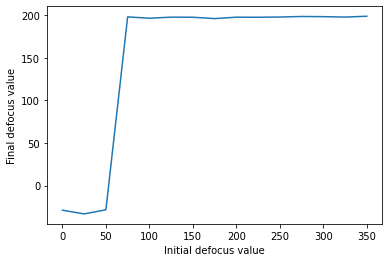

In [15]:
plt.plot(df_values, defocus_values)
plt.ylabel('Final defocus value')
plt.xlabel('Initial defocus value')

filepath = "/home/hremadmin/Documents/Project/ML_files/Work_Jan_19/Part_1_just_df/Initial_df_value/Defocus.jpg"
plt.savefig(filepath, dpi=500)

plt.show()

In [16]:
# For an initial df = 200, the gradient should be zero- how can we check this?

In [18]:
# Constants
n_iterations = 2000
learning_rate = 1e-1
loss_multiplier = 1e9

runtime, loss, defocus_final = main(n_iterations, learning_rate, loss_multiplier, 200.0)


Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([-3.4079e-13])


In [19]:
# Hmm, how odd? It should be equal to zero
# but in all fairness it's pretty close to zero
# Ask Tiarnan